<a href="https://colab.research.google.com/github/qursaan/diffusion-tutorial/blob/main/01_diffusion_models_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models from Scratch

## Understanding Diffusion Models Step by Step

This notebook breaks down diffusion models in the simplest way to help you understand how they work.

We'll start with a small, basic version of a diffusion model and explore:

- How noise is added to data (the corruption process)
- What a UNet is, and how to build a very simple version from scratch
- How to train a diffusion model
- How sampling (generating new data) works

Later, we’ll compare our simple version to the more advanced `diffusers` library (specifically the DDPM model). In that part, we’ll look at:

- How their UNet is improved
- How they add noise in a smarter way
- How their training is different
- How they handle time steps
- How they generate final results



## Setup and Imports:

In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## The Data

Here, we'll test the model using a very small dataset: MNIST.

If you want to give the model a slightly harder challenge without changing anything else, you can replace it easily with `torchvision.datasets.FashionMNIST`—it works as a drop-in replacement.


In [ ]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.57MB/s]


In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([9, 7, 9, 2, 0, 3, 6, 5])


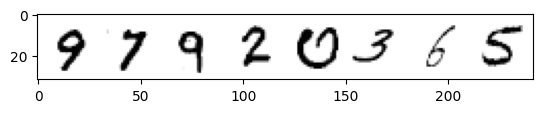

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Each image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1.

## The Corruption Process

Let’s say you don’t know how diffusion models work in detail, but you know the idea is to gradually add noise to data. So how might you do that?

We’ll create a simple function that adds noise, and lets us control how much noise is added using a parameter called `amount`.

Here’s the idea:

```python
noise = torch.rand_like(x)
noisy_x = (1 - amount) * x + amount * noise
```
When amount = 0, we get the original input x (no noise).

When amount = 1, we get pure random noise.

Values between 0 and 1 mix the input and noise proportionally.

The output stays within the same value range (0 to 1), which is nice and stable.

This approach is simple to implement. Just be careful with tensor shapes to avoid broadcasting issues.

In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

And we can look at the results visually to make sure our corruption process is working as expected:

By applying different noise levels and displaying the images, we can see how the original input gradually turns into noise as the `amount` increases.

This gives us a quick sanity check that our noise-adding function behaves the way we want it to.


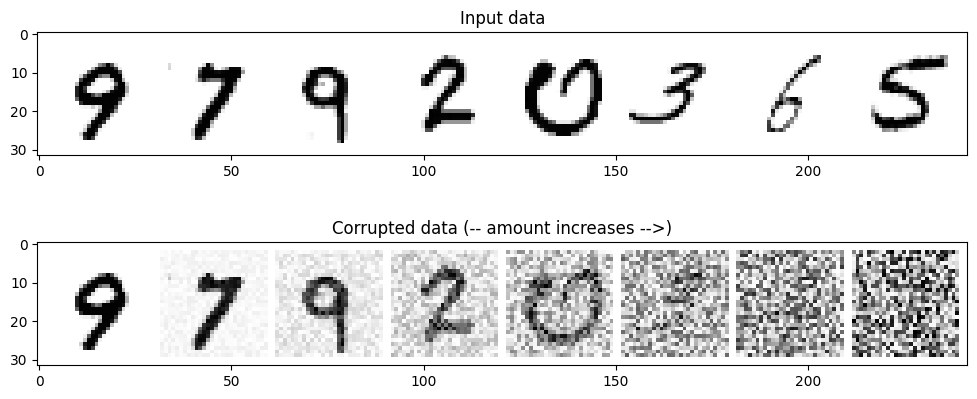

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

As the noise amount gets closer to 1, our images start to look like pure random noise. But for most noise levels (like 0.2, 0.5, or even 0.7), you can often still recognize the digit.

Is this the best way to add noise? Maybe not.

This simple method helps us understand the idea, but it may not be optimal. For real diffusion models, we often use Gaussian noise with more careful scheduling over many steps, which gives the model a smoother and more controlled learning process.

Still, this basic version is a great starting point for building intuition.


## The Model

We want to build a model that takes a noisy 28x28 image and returns an image of the same size as output. A common and effective architecture for this is called a **UNet**.

Originally designed for medical image segmentation tasks ([source](https://arxiv.org/abs/1505.04597)), a UNet has two main parts:

- A **downward path** (or encoder), where the image is gradually compressed using convolutional layers.
- An **upward path** (or decoder), where the data is expanded back to its original size.

What makes UNet special is the use of **skip connections**, which connect matching layers from the down and up paths. This helps preserve important details and makes training easier by allowing gradients and features to flow more effectively.

For this simplified demo, we’ll build a **minimal version**:
- The input is a one-channel (grayscale) image.
- We’ll use 3 convolutional layers for the down path (`down_layers`), and 3 for the up path.
- We’ll connect each down layer to its matching up layer using skip connections.
- We'll use simple `max pooling` to downsample and `nn.Upsample` to upsample, instead of more complex learned layers.

Here’s a diagram of the architecture showing how many channels each layer outputs.


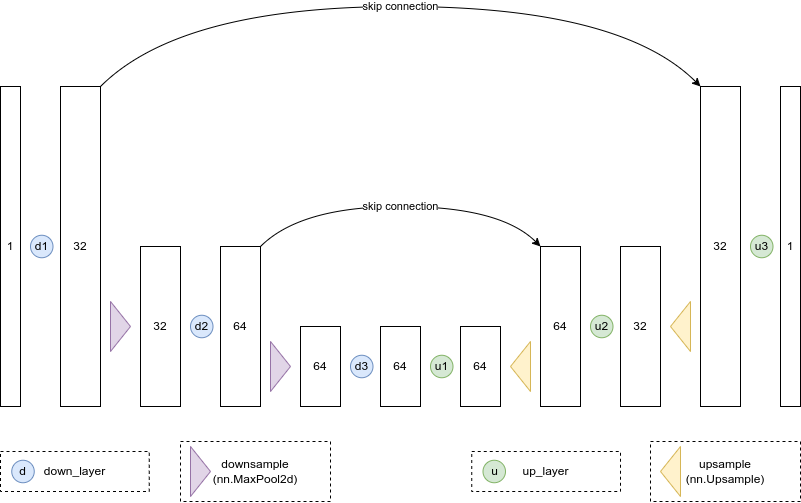


This is what that looks like in code:

In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

We can verify that the output shape is the same as the input, as we expect:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

This network has just over 300,000 parameters:

In [ ]:
sum([p.numel() for p in net.parameters()])

309057

You can explore changing the number of channels in each layer or swapping in different architectures if you want.

## Training the Network

What exactly should the model learn to do?

For this simple demo, we’ll keep things straightforward:  
Given a noisy version of an image (`noisy_x`), the model should try to predict what the original clean image (`x`) looked like.

We’ll measure how close the model’s output is to the original using **mean squared error (MSE)**.

### Training Steps:
1. Get a batch of clean training images.
2. Add random amounts of noise to them.
3. Feed the noisy images through the model.
4. Compare the model’s output to the original clean images using MSE.
5. Update the model’s weights based on the loss.

Feel free to play around with this process — try different noise strategies, architectures, or loss functions to see if you can improve the results!


Finished epoch 0. Average loss for this epoch: 0.025702
Finished epoch 1. Average loss for this epoch: 0.019977
Finished epoch 2. Average loss for this epoch: 0.018351


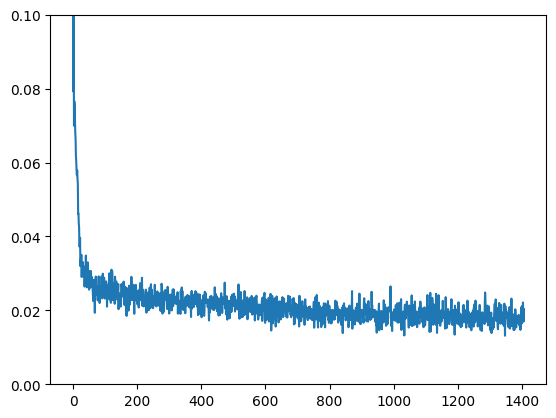

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

We can try to see what the model predictions look like by grabbing a batch of data, corrupting it by different amounts and then seeing the models predictions:

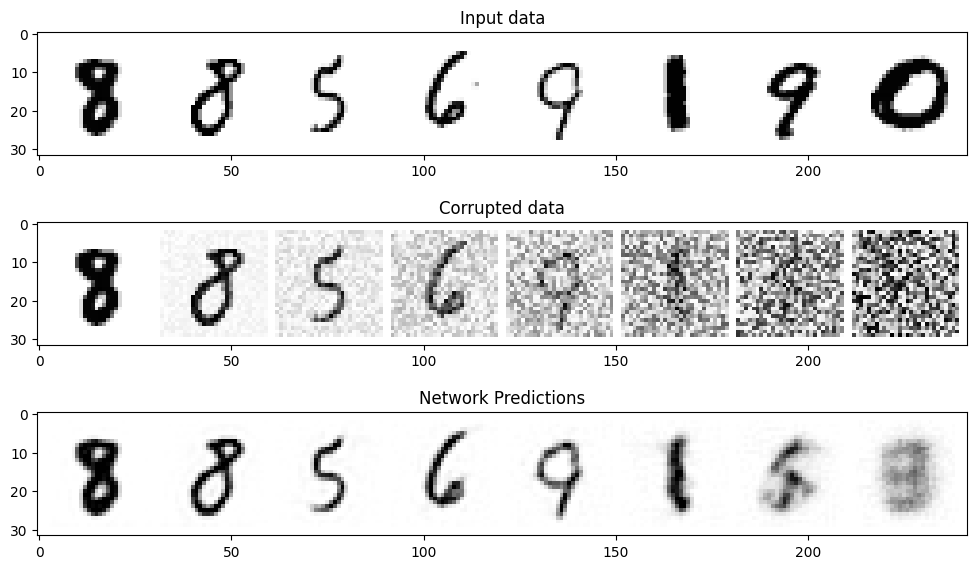

In [ ]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

You can see that at **lower noise levels**, the model does a pretty good job at cleaning up the images and recovering the original digits.

But as the **noise level increases**, the model has less useful information to work with.

By the time the noise amount reaches `1`, the input is just random noise. At that point, the model can't really guess what the original image was, so it outputs a **blurry average**, close to the dataset's mean image — trying to "hedge its bets" by producing something generic.


## Sampling

You might be wondering: if the model struggles at high noise levels, how can we use it to generate images starting from pure noise?

Here’s a simple idea:

- **Start with random noise.**
- Feed it into the model to get a denoised prediction.
- But instead of fully trusting that prediction, just move a small step (like 20%) toward it.
- This gives us a *slightly less noisy image* with a bit of structure.
- Feed this new image back into the model and repeat the process.

Each time, we take a small step in the direction of the model's prediction. As we go through more steps, the noise reduces, and clearer shapes begin to emerge. Eventually, we end up with a full image!

> The key idea: the model isn’t perfect in one step — but by gradually improving and refining over multiple steps, we get a good result.

Here’s a visual example using just 5 steps. On the **left**, you’ll see the noisy input at each stage. On the **right**, the model’s denoised prediction. Even in the first step, the model tries to denoise — and with each small move, the prediction gets clearer.


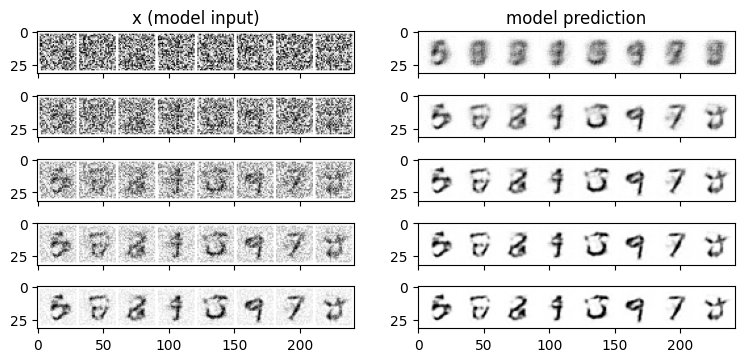

In [ ]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

We can split the process up into more steps, and hope for better images that way:

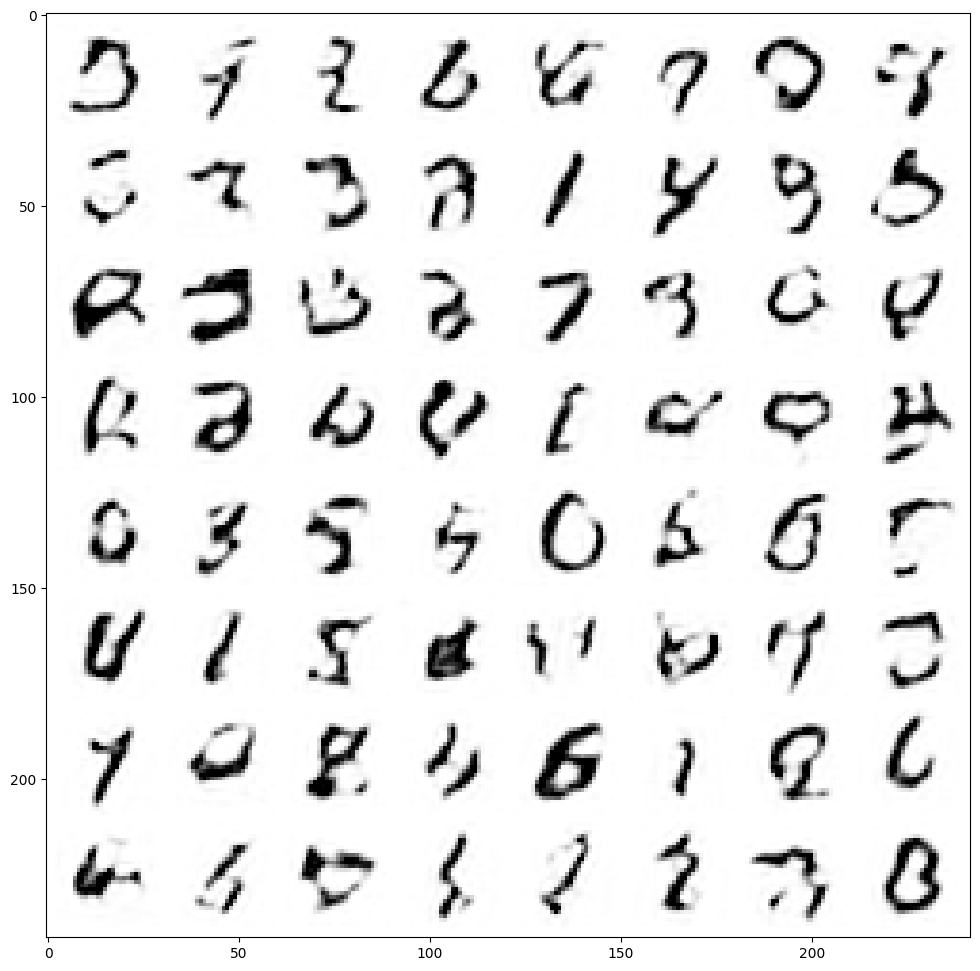

In [ ]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Not perfect, but you can start to see some **recognizable digits** in the generated images!

There’s definitely room for improvement. You can try:
- Training for more epochs (e.g., 10 or 20)
- Adjusting the model architecture
- Tuning the learning rate or optimizer
- Experimenting with different noise schedules


## Comparison to DDPM

Now let’s compare our simple implementation to the more advanced **DDPM (Denoising Diffusion Probabilistic Models)** used in the `diffusers` library.

Here’s what’s different:

- The `diffusers` library uses a more advanced version of UNet (`UNet2DModel`) compared to our simple `BasicUNet`.
- The way noise is added (corruption process) is handled differently, often with a carefully planned **noise schedule**.
- The model doesn’t try to predict the clean image — instead, it learns to **predict the noise** that was added.
- The model is **conditioned on the noise level**, meaning it knows how much noise was added by receiving a `timestep` input during training.
- There are **better sampling strategies** available, which can generate images more efficiently and with better quality than our basic method.

Although newer models have improved on DDPM, this comparison gives you a good sense of the **key design choices** available in diffusion models.

> Want to go deeper? Check out the paper:  
> [*Elucidating the Design Space of Diffusion-Based Generative Models*](https://arxiv.org/abs/2206.00364) — it explores these ideas in detail and offers tips for improving performance.

And if all this feels overwhelming — no problem! You can skip the rest of the notebook and return to it later when you’re ready to explore more.


### The UNet

The `UNet2DModel` from the `diffusers` library is a more advanced version of our simple UNet, with several useful enhancements:

- **GroupNorm**: Applies group normalization to help stabilize training.
- **Dropout**: Helps prevent overfitting and adds regularization.
- **Multiple ResNet layers** per block: Adds more depth and expressiveness (when `layers_per_block > 1`).
- **Attention mechanisms**: Usually added to the lower-resolution blocks to help the model focus on important features.
- **Timestep conditioning**: The model is aware of the noise level (`t`) during training and generation.
- **Learnable downsampling and upsampling**: Unlike our basic model which used fixed operations (like max pooling), these layers are trainable, improving performance.

Let’s now create and take a look at the `UNet2DModel` in action.


In [ ]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

As you can see, there's **a lot more happening** under the hood with `UNet2DModel` compared to our `BasicUNet`.

These extra features and architectural enhancements give it **significantly more parameters**, which means:

- It can learn more complex patterns
- It usually performs better, especially on harder tasks
- But it also requires more compute and memory to train

This makes it a powerful choice for real-world diffusion models.


In [ ]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

We can re-use the same training process as before, but now with `UNet2DModel` instead of our original `BasicUNet`.

There’s just one main difference:  
The new model expects **both the input image (`x`) and a `timestep` (`t`)** as inputs.

In this demo, we keep things simple by always passing `t = 0`. This shows that the model still works even without timestep conditioning, and keeps the sampling code straightforward.

> Want to experiment? Try setting `t = amount * 1000` to give the model a timestep that corresponds to the level of noise added — this is closer to how it's done in real diffusion models.

Lines changed to support the new model are marked with `#<<<` in the code if you’d like to review them.


Finished epoch 0. Average loss for this epoch: 0.018925
Finished epoch 1. Average loss for this epoch: 0.012785
Finished epoch 2. Average loss for this epoch: 0.011694


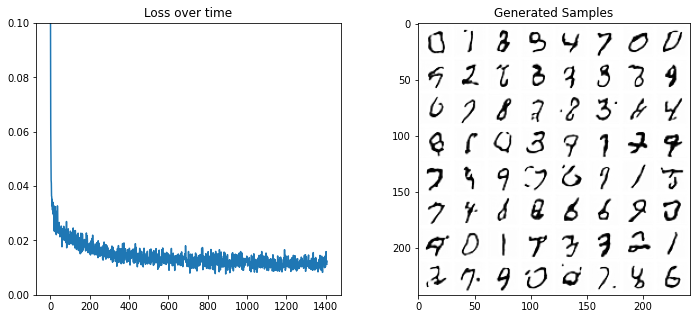

In [ ]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

This already looks **much better** than our first set of results using `BasicUNet`!

The more advanced architecture of `UNet2DModel` helps the model make better predictions, especially when dealing with higher noise levels.

You can try experimenting further by:
- Tweaking the UNet configuration (e.g., more layers, attention, etc.)
- Training for more epochs
- Adjusting the optimizer or learning rate

These changes can help you get even better performance!


### The Corruption Process

In the DDPM (Denoising Diffusion Probabilistic Models) framework, the corruption process adds a **small amount of noise** at each timestep.

Given an image at timestep \( x_{t-1} \), the next noisier version \( x_t \) is computed as:

\[
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \, \mathbf{x}_{t-1}, \beta_t \mathbf{I})
\]

This means:
- We scale the image by \( \sqrt{1 - \beta_t} \)
- We add noise scaled by \( \beta_t \)
- \( \beta_t \) controls how much noise is added at timestep \( t \)

To avoid repeating this process for every single step (like doing it 500 times), we can directly jump from the original image \( x_0 \) to any timestep \( x_t \) using this formula:

\[
q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \, \mathbf{x}_0, \sqrt{1 - \bar{\alpha}_t} \, \mathbf{I})
\]

Where:
- \( \bar{\alpha}_t = \prod_{i=1}^t \alpha_i \)
- \( \alpha_i = 1 - \beta_i \)

The math may seem intimidating at first, but don’t worry — the **scheduler** handles all the calculations for us in code.

> Tip: You can uncomment the next code cell to view the implementation.

You can also plot:
- `sqrt_alpha_prod` → how much of the **original image** remains at each step
- `sqrt_one_minus_alpha_prod` → how much **noise** is mixed in over time

These help you visualize how the input and noise contributions change across timesteps.


In [ ]:
#??noise_scheduler.add_noise

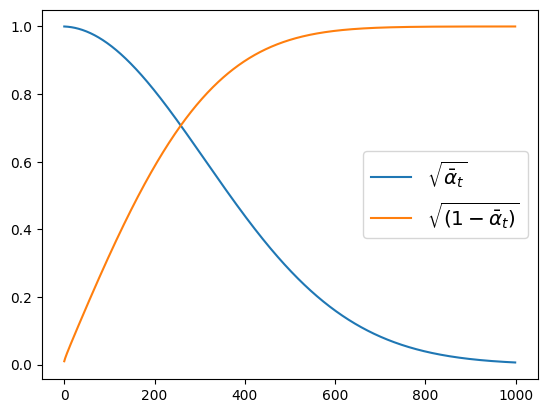

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

At the start, the noisy version of the image is still **mostly the original** — because `sqrt_alpha_prod` is close to 1, meaning very little noise has been added yet.

But as time goes on:
- The **original image contribution** drops
- The **noise component** increases
- Eventually, the data becomes nearly pure noise

This happens faster than in our earlier linear method (where we mixed `x` and noise using a simple `amount` param


X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


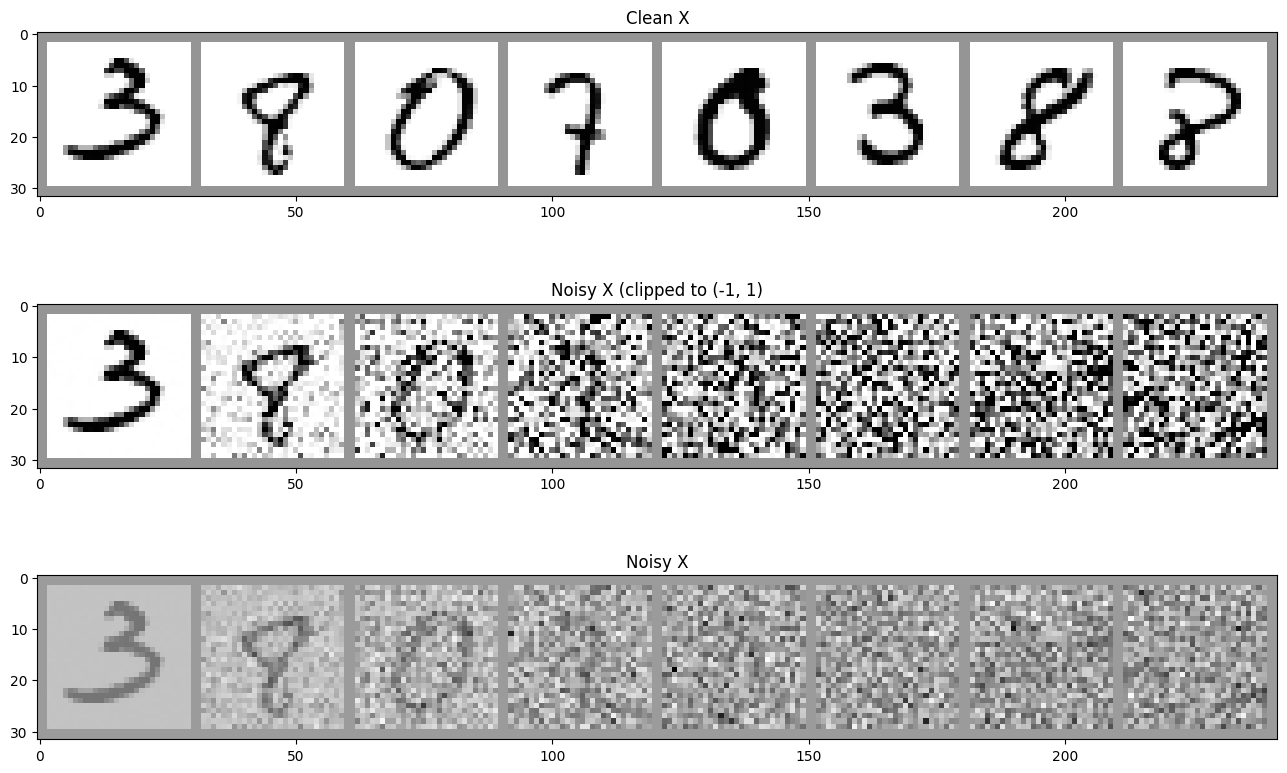

In [ ]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

Another important difference in DDPM: the noise added at each step comes from a **Gaussian distribution** (`torch.randn`, with mean 0 and standard deviation 1), not a **uniform distribution** (`torch.rand`) like we used in our original `corrupt` function.

This aligns better with the theory behind diffusion models and leads to more natural results.

Also, in most implementations, the **training data is normalized** to match the noise distribution. For example, in the other notebook, you'll see this transform:

```python
transforms.Normalize(0.5, 0.5)
```
This maps image pixel values from the range (0, 1) to (-1, 1), which is "good enough" for most diffusion setups.

In this notebook, we didn’t apply that normalization during training — but in the visualization cell above, it’s added to help display the corrupted images in a more accurate and consistent way.

### Training Objective

In our simple example, we trained the model to **predict the denoised image** directly.

However, in **DDPM** (and many modern diffusion models), the model is trained to **predict the noise** that was added during the corruption process — not the clean image.

This subtle change simplifies the math and improves training stability.

Here’s what that looks like in code:

```python
noise = torch.randn_like(xb)  # << Note: using randn (Gaussian noise), not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise)  # We're using noise as the target
```
So instead of asking the model “What did the original image look like?”, we ask,
“What noise was added here?”
Once we know the noise, we can subtract it out to recover the original.

You might think that predicting the **noise** (which we can subtract to recover the image) is the same as directly predicting the **denoised image**. So why do most diffusion models prefer predicting the noise?

At first glance, it might seem like just a matter of mathematical convenience — but there’s more going on.

### Why Predict Noise?

During training, we randomly sample timesteps and compute the loss based on that timestep. Here's the catch:  
**Different training objectives result in different “implicit weighting” of loss contributions across timesteps.**

- **Predicting the noise** tends to emphasize **lower-noise timesteps** more.
- **Predicting the image** or other targets might distribute that emphasis differently.

This can impact how well the model learns at different noise levels.

### Variations in Objective

Researchers have explored alternatives, including:

- **Velocity (`v`) prediction**: Combines both the noise and the image in a single target (used in *"Progressive Distillation for Fast Sampling of Diffusion Models"*).
- **Scaled noise loss**: Adjusts the loss based on how much noise was added, grounded in theory (see *"Perception Prioritized Training of Diffusion Models"*).
- **Experimentally tuned weighting**: Picks targets and weights based on empirical performance (e.g., in *"Elucidating the Design Space of Diffusion-Based Generative Models"*).

### TL;DR

The **training objective matters** — it influences what the model learns and how well it performs. While predicting **noise** (`epsilon` or `eps`) is the current standard, the research community continues to explore better objectives.

Expect to see **more options** supported in libraries and used in different scenarios over time.


### Timestep Conditioning

The `UNet2DModel` takes in two inputs:
- The noisy image `x`
- The `timestep` that tells the model **how much noise** was added

The timestep is transformed into an **embedding**, which is then injected into the model at various points.

### Why include timestep conditioning?

The idea is simple:  
By telling the model **how noisy** the input is (i.e. which step in the corruption process it came from), the model can make **more informed predictions**.

While you *can* train a model without this information, studies show that **timestep conditioning often improves performance**, especially in more complex tasks.

As a result, **most diffusion models in current research and libraries use timestep conditioning** by default.


### Sampling

So, how do we **generate new images** using a trained diffusion model?

We have a model that can predict either:
- The **noise** in a noisy image, or
- The **denoised version** of that image.

We could try generating an image in just **one step** by feeding the model pure noise and asking it to denoise — but as we saw earlier, that usually doesn’t work very well.

Instead, we use a **multi-step approach**:
- Start with random noise
- Use the model to remove a little noise at a time
- Repeat this process over many steps, gradually refining the image

### Key Questions in Sampling Design

There are many ways to design a sampling process. Here are a few important decisions:

- **Step size**:  
  What kind of **noise schedule** do you follow? (i.e. how much noise is removed at each step)

- **Model usage**:  
  - Do you rely only on the current model prediction?  
    (like **DDPM**, **DDIM**, and other simple samplers)  
  - Or do you evaluate the model multiple times to estimate **higher-order gradients** for a better step?  
    (used in higher-order methods and ODE solvers)  
  - Or do you keep a **history of past predictions** to inform better updates?  
    (used in linear multi-step and ancestral samplers)

- **Stochasticity vs Determinism**:  
  Do you inject **extra noise** (sometimes called **churn**) during sampling to encourage variety?  
  Or do you keep the process **completely deterministic**?  
  Many samplers (like **DDIM**) let you control this with a parameter (e.g. `eta`) so you can choose how random or stable your results are.

In short, sampling is a delicate balancing act — choosing the right path to go from **pure noise** to a **coherent image**, one small step at a time.
